* Press *Shift + Enter* to run each cell.

#### CMB Instrumentation Summer School 2022
### Laser Spectroscopy: Measuring Materials' Optical Properties
Shreya Sutariya (shreyas@uchicago.edu), ERC 568
This is the hands-on component of the FLS lab.

Today's lab will center on reflection measurements of a common plastic called high-density polyethelene (HDPE). After measuring and plotting the measurement, we will plot its simulated performance and compare. Finally, we fit to get the exact index of refraction $n$ of the material. (Time permitting we will also measure: LPE, MF-114, non-ARC alumina).


#### Today's Objectives:
- See `Notebook1_Laser_Spec_Background.ipynb` for material on understanding the measurement instrument and reflection setup.
- *Exercise 1:* Take reflection measurements of our samples.
- *Exercise 2:* Simulate what reflection of such a material should look like.
- *Exercise 3:* Fit our measurement to the model to get the index of refraction of our sample. <br>
&#x2192; We can understand a material more precisely by knowing its complex index of refraction, $\tilde{n} = n + ik$ (we won't be doing this fit today), where the imaginary component $k$ determines the absorptivity of the material and the real part $n$ is what we normally refer to as the index of refraction.

### Exercise 1: Reflection Measurements
As you take reflection measurements, think about the following:

* What can introduce noise in our measurement? What are ways we can reduce this?
* Think about the transmission setup from Figure 1 in `Notebook1`. What challenges and differences could come up in a transmission measurement?

#### Measurement Procedure:

In addition to measuring the sample's performance across a frequency range, we also have to take a calibration measurement to normalize the sample's measurement and get its reflectivity. We use a metal plate for this calibrating measurement, which serves as our 100% reflection.

For both the metal plate and the sample, we will get the electric field amplitude as it changes with respect to frequency. Then, to convert from amplitude to power (which scales as $~ |E|^2$), we square the sample and calibration plate amplitudes. To normalize our sample's measurement, we divide out the calibration plate: $R = (E_{sample} / E_{plate})^2$

***
1. Set the sweep parameters in the TOPAS software: 
    - Suggested values: `Start frequency: 60 GHz`, `End frequency: 180 GHz`, and `Step size: 0.1 GHz`
    
<div>
<img src="https://docs.google.com/uc?export=download&id=1pf6YnH8VsGozuvy6vaMmHRS71GHmH3Bl" width="170" align='left'/>
</div>

<br clear="left"/> 

2. Set the current emitting frequency to `60 GHz`.
<div>
<img src="https://docs.google.com/uc?export=download&id=1IWShljcloak-YwwkGMmGolWaf01HoHq6" width="170" align='left'/>
</div>

<br clear="left"/>

3. Insert metal plate into sample holder; use an allen wrench and the screws to use washers to hold the plate in place.
<div>
<img src="https://docs.google.com/uc?export=download&id=1IIPgCcTzXdFPkWCQEu7jdpgS6pygAQ9W" width="1000" align='center'/>
</div>

3. Press `Scan up` to start the sweep.
<div>
<img src="https://docs.google.com/uc?export=download&id=1-vvNmvX5-buD8hUECc0-IMgxXsIKKhdj" width="200" align='left'/>
</div>

<br clear="left"/> 

4. After the sweep is completed, choose the data columns to save and save your data in the `GroupX` folder with the name `r_plate_1_60-180GHz.txt`.

<div>
<img src="https://docs.google.com/uc?export=download&id=1kDDvMF5b8OmhVY5Ct2DlNOhdxHbB9cg1" width="500" align='left'/>
</div>

<br clear="left"/> 

5. Repeat these steps but now replacing the metal plate in step (3.) with the sample of choice (for the first measurement, use HDPE, for other measurements, ask me (Shreya) for more samples). Save the sample in the same folder as above with the sample's name, e.g. `r_hdpe_1_60-180GHz.txt`


## 6. IMPORTANT: Saving your data

* ### Upload saved data onto the public [Google Drive Folder](https://drive.google.com/drive/folders/1dnvBpeqmDDmX2h6gwJYBr5fP7hnbjLUJ?usp=sharing) (upload your group's folder with the name `GroupX`)

### Exercise 1.a.: Plotting our measurement
Here we plot the measurement from Exercise 1.

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import scipy.optimize as optimize

**User input:** Enter your group name in the following format.

In [11]:
group_folder_name = 'GroupX'

In [12]:
# Run this cell as it is
# Next we have some useful functions/classes to smooth our data if needed, as well as to help us plot it.

def smooth(x,window_len=11,window='hanning'):
    """smooth the data using a window with requested size.
    NOTE: length(output) != length(input), to correct this: return y[(window_len/2-1):-(window_len/2)] instead of just y.
    """
    if x.ndim != 1:
        print('smooth only accepts 1 dimension arrays.')
    if x.size < window_len:
        print('Input vector needs to be bigger than window size.')
    if window_len<3:
        return x
    if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        print('Window is on of \'flat\', \'hanning\', \'hamming\', \'bartlett\', \'blackman\'')
    s=np.r_[x[window_len-1:0:-1],x,x[-2:-window_len-1:-1]]
    if window == 'flat': #moving average
        w=np.ones(window_len,'d')
    else:
        w=eval('np.'+window+'(window_len)')
    y=np.convolve(w/w.sum(),s,mode='valid')
    return y

class fls_rt(object):
    def __init__(self, file_name):
        self.file_name = file_name
        return
    
    def load_data(self, path_ = "/Users/Shreya Sutariya/school_data/"+group_folder_name+'/', col = 2): # col sets the column that we're pulling out. 
        '''
        Column indices correspond to: 0-freq set, 1-Thz photocurrent, 2-freq actual, 3-amplitude, 4-phase
        '''
        data = np.genfromtxt(path_+self.file_name, skip_header=1)
        col_data = data[:,col]
        return col_data
    
    def get_rt(self, calibration_freq, calibration_amplitude, sample_freq, sample_amplitude):
        '''check if the amplitude arrays are the same lengths'''# check if the arrays are the same lengths
        len_calib = len(calibration_amplitude)
        len_sample = len(sample_amplitude)

        if len_calib != len_sample:
            # interpolate for the calibration and sample arrays to match in length if needed
            f = scipy.interpolate.interp1d(calibration_freq, calibration_amplitude, bounds_error=False, fill_value='extrapolate')
            calibration_amplitude = f(sample_freq)
            rt = (sample_amplitude/calibration_amplitude)**2
            
        rt = (sample_amplitude/calibration_amplitude)**2
        return sample_freq, rt
    
    def get_rt_smooth(self, calibration_freq, calibration_amplitude, sample_freq, sample_amplitude, window_len_ = 11):
        ''' Smooth all arrays and then repeat get_rt'''
        cal_f_smooth = smooth(calibration_freq, window_len = window_len_)
        cal_a_smooth = smooth(calibration_amplitude, window_len = window_len_)
        sam_f_smooth = smooth(sample_freq, window_len = window_len_)
        sam_a_smooth = smooth(sample_amplitude, window_len = window_len_)
        f, rt = self.get_rt(cal_f_smooth, cal_a_smooth, sam_f_smooth, sam_a_smooth)
        return f, rt
    
    def save_file(self, freq, refl, name_save, path_save = '/Users/Shreya Sutariya/school_data/'+group_folder_name):
        header_ = 'Frequency(GHz), Reflectivity'
        data = np.array([freq, refl])
        data = data.T
        outfile = open(path_save+name_save, 'w')
        outfile.write(header_)
        np.savetxt(outfile, data)
        outfile.close()
        print("Your file is saved and stored in: ", path_save+name_save)
        return

**User input:** Enter the file names.

In [156]:
# ### Insert file names here:
hdpe1 = fls_rt("hdpe2_0p25in_60-120ghz.txt")
plate1 = fls_rt("plate2_60-120ghz.txt")

# enter name of file to save (uncomment last line of next cell if you want to save the file with freq, refl)
file_save_as = "hdpe_6p35mm_60-120ghz_refl.txt"

If doing this on your personal computer, use the last four lines with the `path_=` argument and comment out the first four lines. Change the `path_` argument to match wherever you downloaded the files from Google Drive. Otherwise, run the next cell as it is.

In [157]:
# Run cell as it is
hdpe_freq = hdpe1.load_data(col=2) # frequency
hdpe_amplitude = hdpe1.load_data(col=3) # electric field amplitude
plate_freq = plate1.load_data(col=2)
plate_amplitude = plate1.load_data(col=3)

# alumina_freq = alumina1.load_data(path_ = "/Users/(Your Name)/Downloads/", col=2) # frequency
# alumina_amplitude = alumina1.load_data(path_ = "/Users/(Your Name)/Downloads/", col=3) # electric field amplitude
# plate_freq = plate1.load_data(path_ = "/Users/(Your Name)/Downloads/", col=2)
# plate_amplitude = plate1.load_data(path_ = "/Users/(Your Name)/Downloads/", col=3)

f, r = hdpe1.get_rt(plate_freq, plate_amplitude, hdpe_freq, hdpe_amplitude)
f_smooth, r_smooth = hdpe1.get_rt_smooth(plate_freq, plate_amplitude, hdpe_freq, hdpe_amplitude, window_len_=11)
# alumina1.save_file(f_smooth, r_smooth, file_save_as, path_save = "/Users/Shreya Sutariya/school_data/")

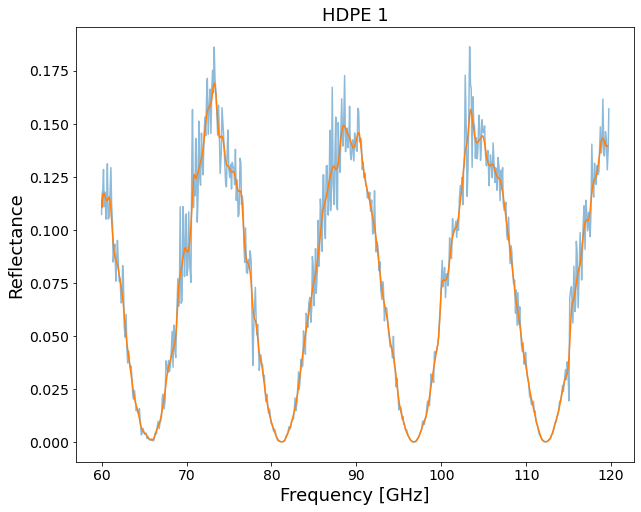

In [158]:
# Run cell as it is
plt.figure(figsize=(10, 8))
plt.title("HDPE 1", fontsize=18)
plt.plot(f, r, alpha=0.5)
plt.plot(f_smooth, r_smooth)
plt.xlabel("Frequency [GHz]", fontsize=18)
plt.ylabel("Reflectance", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

#### Trouble Shooting: Standing Waves

You'll notice that there are quite a few wiggles at the peaks in the measurement.

- What do you think these could be due to? What we do know about standing waves?
- Where in the system could we imagine standing waves originating?
- What are methods to mitigate standing waves? (Hint: Look at materials on the optical bench)
- Why did we put Eccosorb (black absorbing foam) on the sample mount?
*** 

*** 

***
After the adjustment to the setup to try and mitigate standing waves, re-do the measurement steps from Exercise 1 (re-measure plate and sample, this time saving the files with the next measurement number, e.g. `plate2_60-180GHz.txt` and `hdpe2_60-180GHz.txt` if this is the second measurement of the day). 

Then, replot the data using these two code cells:

In [53]:
# USER INPUT: Insert file names here
hdpe2 = fls_rt("hdpe2_0p75in_60-120ghz.txt")
plate2 = fls_rt("plate2_60-120ghz.txt")

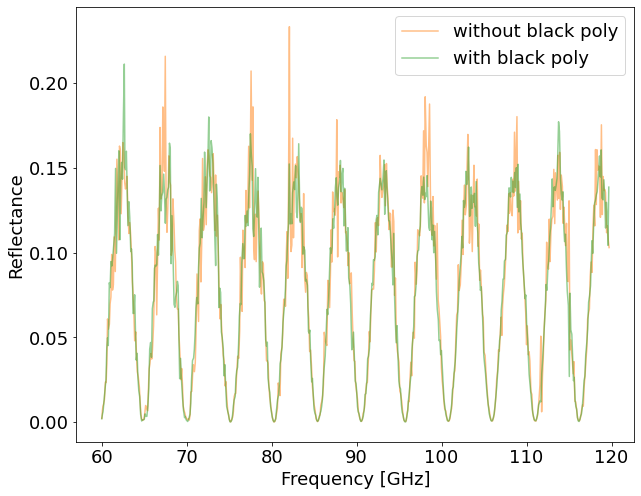

In [60]:
# Run cell as is
hdpe_freq2 =hdpe2.load_data(col=2) # frequency
hdpe_amplitude2 =hdpe2.load_data(col=3) # electric field amplitude

plate_freq2 = plate2.load_data(col=2)
plate_amplitude2 = plate2.load_data(col=3)

f2, r2 = hdpe2.get_rt(plate_freq2, plate_amplitude2, hdpe_freq2, hdpe_amplitude2) # un-smoothed data
f_smooth2, r_smooth2 = hdpe2.get_rt_smooth(plate_freq2, plate_amplitude2, hdpe_freq2, hdpe_amplitude2, window_len_=11)#smoothed

plt.figure(figsize=(10, 8))
plt.title("", fontsize=18)
# plt.plot(f_smooth2, r_smooth2, "C1")
plt.plot(f, r, "C1", alpha=0.5, label='without black poly')
plt.plot(f2, r2, "C2", alpha=0.5,label='with black poly')
plt.xlabel("Frequency [GHz]",fontsize=18)
plt.ylabel("Reflectance",fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(fontsize=18)
plt.show()

### Exercise 2: Simulating the Material Performance

We can model a slab of some material with parallel edges as a Fabry-Perot cavity. As waves travel in and reflect back from the second boundary, interference occurs with the incoming rays, resulting in a periodic intereference pattern.

We can determine what the exact spacing of this intereference pattern should look like by knowing what the thickness $d$ of the sample is, as well as the index of refraction of the material $n$, and the angle of incidence during our reflection measurement.

* Measure the material thickness in mm using the caliper provided.
***
***
* Determine the angle of incidence by (1) taking a bird's eye view photo of the setup and (2) using [this site](https://www.ginifab.com/feeds/angle_measurement/) to measure the angle between the receiver and transmitter, going out to the sample. Divide this value by two. <font color="red">I will give you this value, ask me (Shreya) for the angle of incidence.</font>
***
***

Note: This code does not take into account any absorptive properties of the material!

In [73]:
# Run cell as is
def AiryR(params):
    '''n0, n, freq, d, angleI, R = params 
    '''
    n0, n, freq, d, angleI = params
    R = ((n-1)/(n+1))**2
    c = 3e8
    lamb = c/freq
    omega = 2*np.pi*(c/lamb)
    k = n*omega/c
    k0 = n0*omega/c
    angleT = np.arcsin((n0/n)*np.sin(angleI))
    
    l = d*np.cos(angleT)
    s = 2*d*np.sin(angleT)/np.cos(angleT)
    a = s*np.sin(angleI)
    
    diff_phase = 2*k*l - k0*a
    T = (1 + 4*R/(1-R)**2*(np.sin(diff_phase/2))**2)**(-1)
    return 1-T

def functionAiryR(n1, constants_, ff_):
    angleI_deg, thickness_mm = constants_
    
    angleI_rad = np.radians(angleI_deg) # units: radians
    thickness_m = thickness_mm*1e-3
#     thickness_m = thickness_in*0.0254 # units: mm
#     print("this is thckness:", thickness_m)
    ff_Hz = ff_*1e9 # units: Hz
    
    n0 = 1 # index of air: n0 | n1 | n0 where n1 is the index of the material
    params = [n0, n1, ff_Hz, thickness_m, angleI_rad]
    
    R = AiryR(params)
    return R

**User input:** In the next cells, plot a simulated version of what interference pattern we expect to see:

In [74]:
# 1. Choose your frequency range:
freqs_sim = np.linspace(60, 120, 300) # start freq [GHz], end freq [GHz], number of points

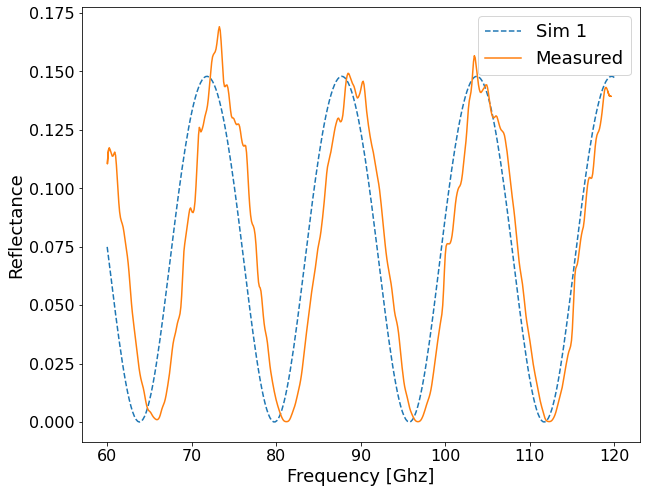

In [85]:
# 2. Choose your parameters 
# a. predicted material index n1 
# b. angle of incidence, theta_i [deg]
# c. material thickness, d [mm]

plt.figure(figsize=(10,8))
plt.title("", fontsize=18)
plt.plot(freqs_sim, functionAiryR(1.5, [8, 0.25*25.4], freqs_sim), '--',label='Sim 1') # functionAiryR(n1, theta_i, d)
# plt.plot(freqs_sim, functionAiryR(1.5, [9, 5], freqs_sim),'--', label='Sim 2') # functionAiryR(n1, theta_i, d)
# plt.plot(freqs_sim, functionAiryR(1.5, [9, 10], freqs_sim),'--', label='Sim 3') # functionAiryR(n1, theta_i, d)
plt.plot(f_smooth, r_smooth, label='Measured')
plt.xlabel("Frequency [Ghz]", fontsize=18)
plt.ylabel("Reflectance", fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=18)
plt.show()

Uncomment out the extra simulation plotting lines and play around with different indices, thicknesses, etc. 
* What do you think will happen to the interference pattern as the material thickness increases?
***
***
* How about as the index of refraction increases?
***
***
Plot our measurement data from Exercise 1 on top of the simulation and compare the two by eye. Play around with the simulation parameters to see how the two can match better.

### Exercise 3: Fitting to the Index of Refraction
Using your measured data from Exercise 1 and the rough parameter estimates from Exercise 2, fit to the material's index of refraction.

In [77]:
def err(n1, constants_, ff_, sampleR):
    model = functionAiryR(n1, constants_, ff_)
    return np.sum((sampleR - model)**2)

Enter the index guess below, as well as the angle of incidence and thickness.

Then, in the `X_fit = optimize.minimize..` line, enter the frequency and reflection of the sample that you want to fit to.

In [78]:
p0 = 1.5 # Best n1 guess from Exercise 2
consts = [8, 0.25*25.4] # theta_i, incidence angle [deg], material thickness d [mm]

# enter the measured frequencies and reflection data in the "arguments (args)":
X_fit = optimize.minimize(err, p0, args=(consts, f_smooth, r_smooth),method="Nelder-Mead") 

In [79]:
n_fit = X_fit.x[0]
print("The result of fitting to the index of refraction is n1 = ", n_fit)

The result of fitting to the index of refraction is n1 =  1.483154296875


Now plot the simulation with this index of refraction and our measured data.

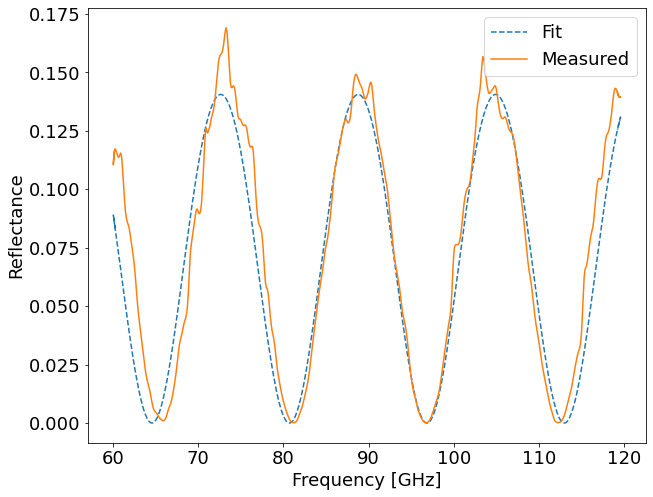

In [81]:
plt.figure(figsize=(10, 8))
plt.title("", fontsize=18)
plt.plot(f_smooth, functionAiryR(n_fit, [8, 0.25*25.4], f_smooth), '--', label='Fit')
plt.plot(f_smooth, r_smooth, label='Measured')
plt.xlabel("Frequency [GHz]",fontsize=18)
plt.ylabel("Reflectance",fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(fontsize=18)
plt.show()

Great! Now we have our fit.

* What could be done to improve the fit? (Remember, we haven't accounted for the imaginary component of the index of refraction here. How well do we trust our measurement of the material thickness? The angle of incidence?)
***
***

***

<div class="alert alert-block alert-success">
<b>Success:</b> You are done with <code>Notebook 2: Reflection</code>! You can now measure another material. If you finish early with the extra materials and have time, check out <code>Notebook 3: Bonus Complex Index fits </code>. 
</div>

Additional materials:
* Low Pass Edge (LPE) filter from 180 to 250 GHz
* Alumina (aluminum oxide) disc from 60-120 GHz

### Additional Material: Low Pass Edge (LPE) Filter

After repeating the measurement steps from Exercise 1 for the plate and LPE (take care with the LPE, it's more fragile), plot the results using the next two cells. The LPE is a metal-mesh filter, described in more detail [here](https://sites.astro.caltech.edu/~moncelsi/metal_mesh_LM_9Feb2012.pdf).

<div>
<img src="https://docs.google.com/uc?export=download&id=1vVZm1R1met9plZrhCE79rd6Qw8666Dt0" width="300" align='center'/>
</div>



In [145]:
# Insert file names here
lpe = fls_rt("lpeA02_30-500Ghz.txt") # change "sample_num" to sample name with the measurment number, e.g. hdpe2
plate = fls_rt("plate02_30-500Ghz.txt") # change plate number to match sample measurement number

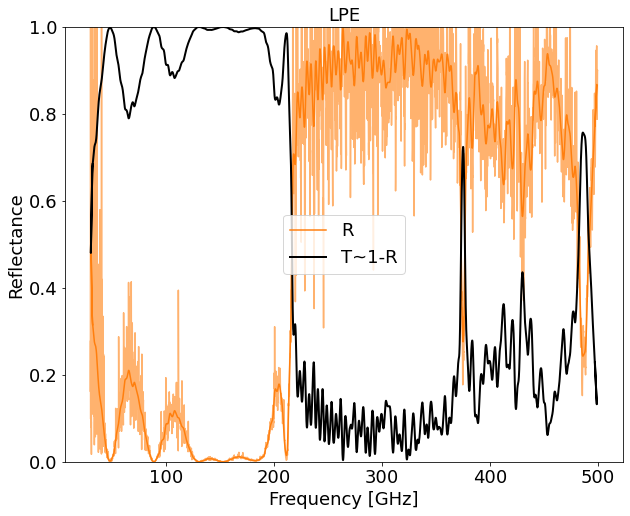

In [155]:
lpe_freq =lpe.load_data(col=2) # frequency
lpe_amplitude =lpe.load_data(col=3) # electric field amplitude

plate_freq = plate.load_data(col=2)
plate_amplitude = plate.load_data(col=3)

f_lpe, r_lpe = lpe.get_rt(plate_freq, plate_amplitude, lpe_freq, lpe_amplitude) # un-smoothed data
f_smooth_lpe, r_smooth_lpe = lpe.get_rt_smooth(plate_freq, plate_amplitude, lpe_freq, lpe_amplitude, window_len_=50)#smoothed
# ^ note, this data is smoothed a lot more

plt.figure(figsize=(10, 8))
plt.title("LPE",fontsize=18)
plt.plot(f_lpe, r_lpe, "C1", alpha=0.6)
plt.plot(f_smooth_lpe, r_smooth_lpe, "C1", label='R')
plt.plot(f_smooth_lpe, 1-r_smooth_lpe, "k", label='T~1-R', linewidth=2)
plt.xlabel("Frequency [GHz]",fontsize=18)
plt.ylabel("Reflectance",fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.ylim(0, 1)
plt.legend(fontsize=18)
plt.show()

* Looking at this plot, high reflection means low transmission. Around which frequency does the LPE stop transmitting and instead reflects heavily?
***
***

#### References

On photomixers and THz lasers:
* Info. Sheet: [*Laser-based terahertz generation & applications*, M. Lang, et al.](https://www.toptica.com/fileadmin/Editors_English/12_literature/03_terahertz/toptica_laser-based_terahertz_generation_and_applications.pdf)
* [*Review of photomixing continuous wave terahertz systems and current appplication trends in terahertz domain*, R. Safian, et al.](https://www.spiedigitallibrary.org/journals/optical-engineering/volume-58/issue-11/110901/Review-of-photomixing-continuous-wave-terahertz-systems-and-current-application/10.1117/1.OE.58.11.110901.full)

More on LPEs:
* [PowerPoint: *Metal-mesh technology: a past and presetn view*, L. Moncelsi, et al.](https://sites.astro.caltech.edu/~moncelsi/metal_mesh_LM_9Feb2012.pdf)
* [*A review of metal mesh filters*, P. Ade, et al.](https://www.spiedigitallibrary.org/conference-proceedings-of-spie/6275/62750U/A-review-of-metal-mesh-filters/10.1117/12.673162.full)